<a href="https://colab.research.google.com/github/Abdulkareem777/Abdulkareem/blob/main/%E3%80%8CGoogLeNet%E3%80%8DCIFAR_100_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> CIFAR-100 -「GoogLeNet」CIFAR-100 Classification</center>
### <center>If you feel my notebook helpful, support with one upvote, thank you👍</center>

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Import Libraries</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lightning --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 40.2 MB/s eta 0:00:00


In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid", font_scale=1.5, font="SimHei", rc={"axes.unicode_minus":False})

import torch
import torchmetrics
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
pl.seed_everything(seed)

INFO: Seed set to 1
INFO:lightning.fabric.utilities.seed:Seed set to 1


1

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Read Dataset</div>

In [4]:
batch_size = 128

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR100(root="./data", train=True, transform=train_transform, download=True)
val_dataset = datasets.CIFAR100(root="./data", train=False, transform=test_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = val_loader

100%|██████████| 169M/169M [00:13<00:00, 12.8MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Visualization</div>

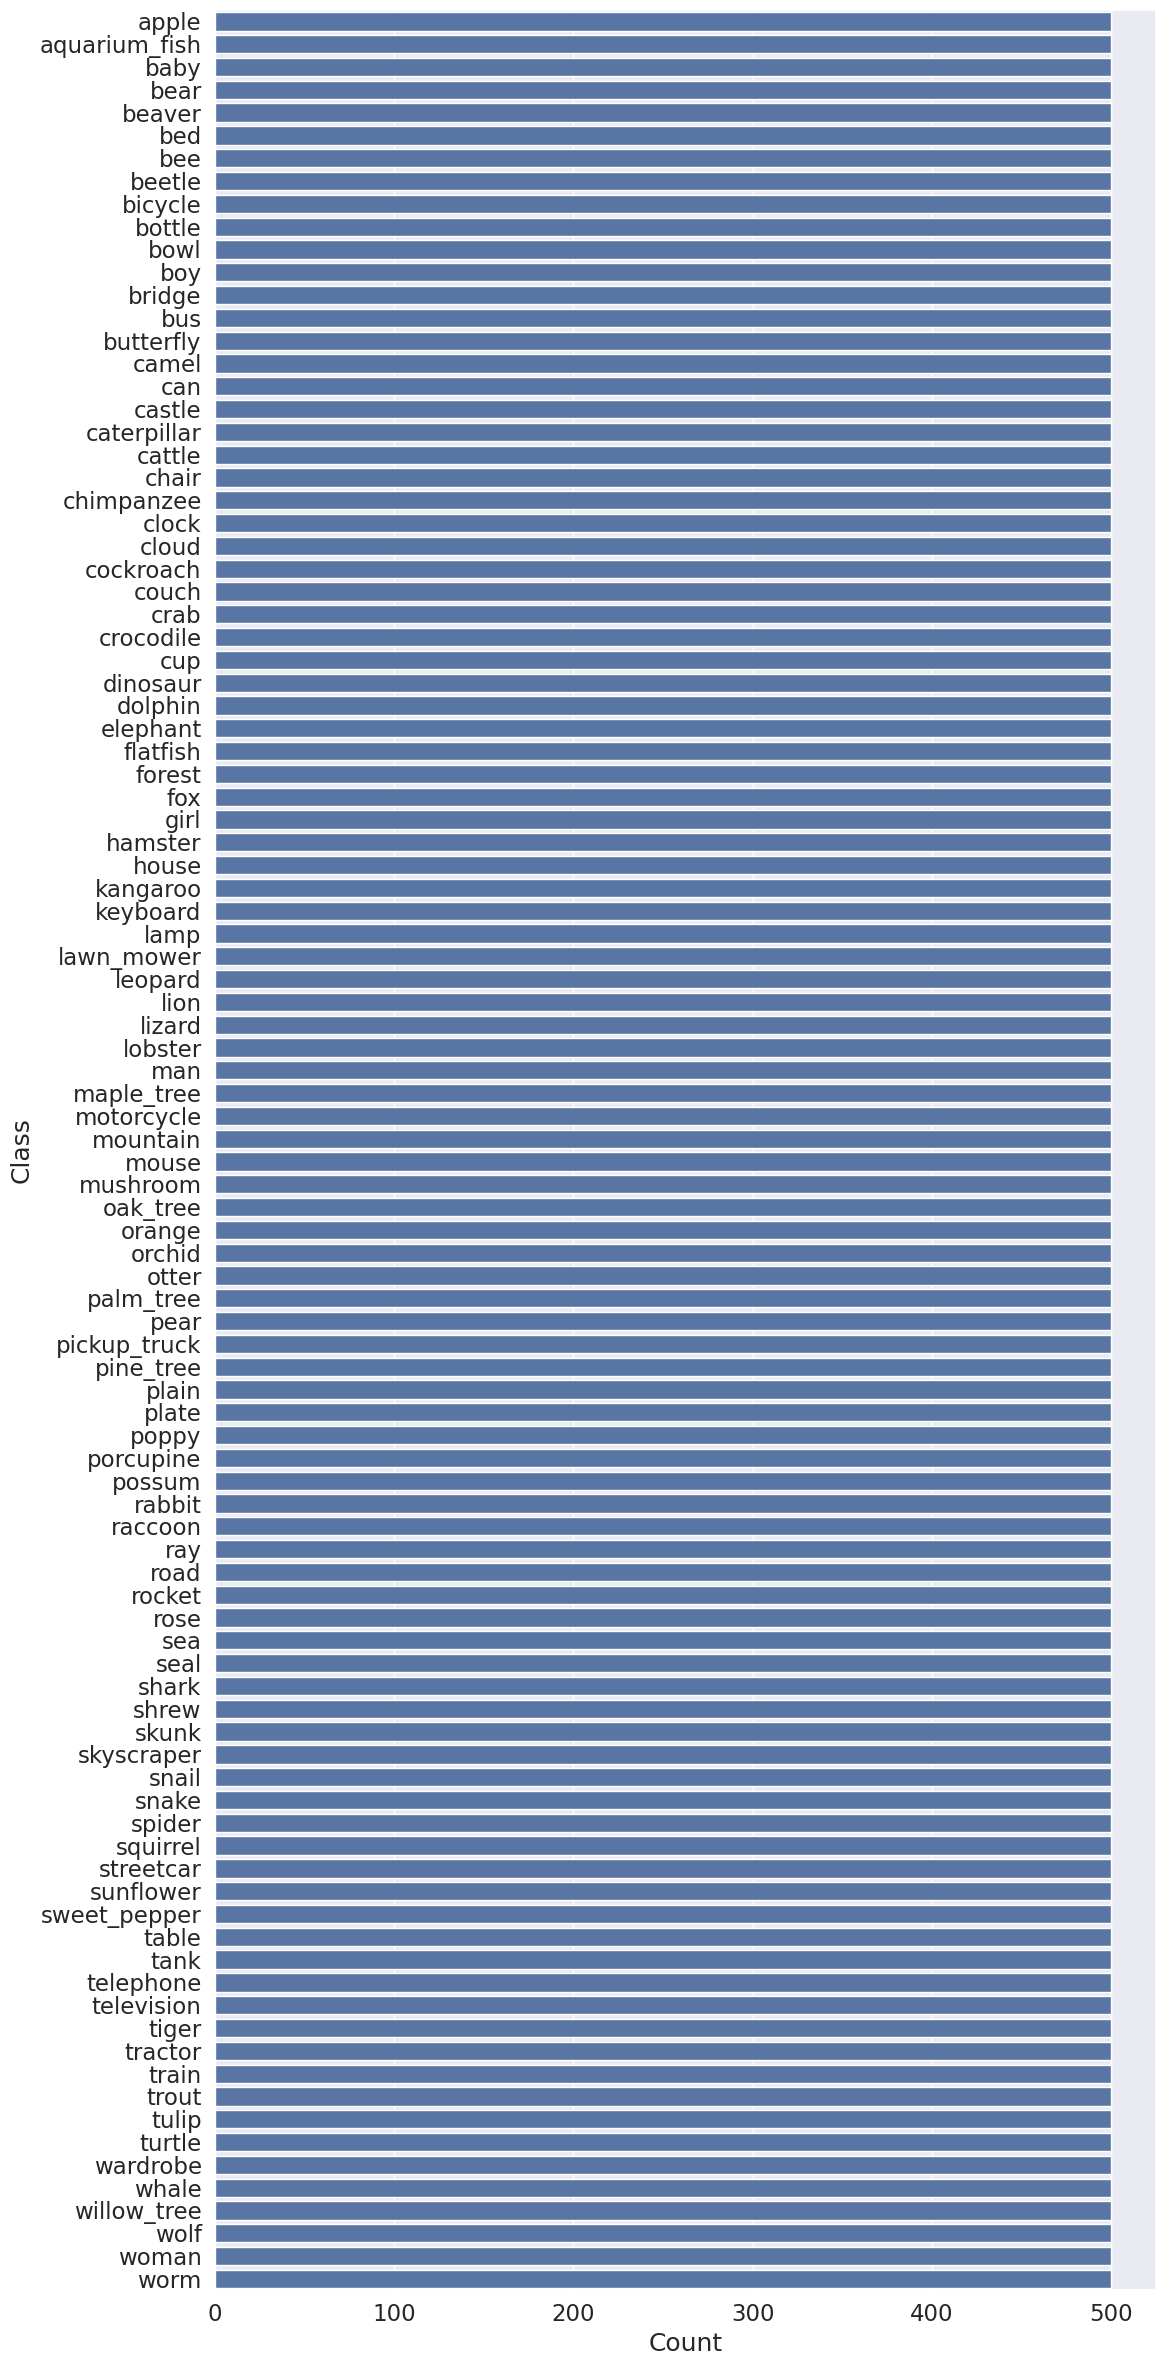

In [5]:
class_names = train_dataset.classes
class_count = [train_dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count})

plt.figure(figsize=(12, 24), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

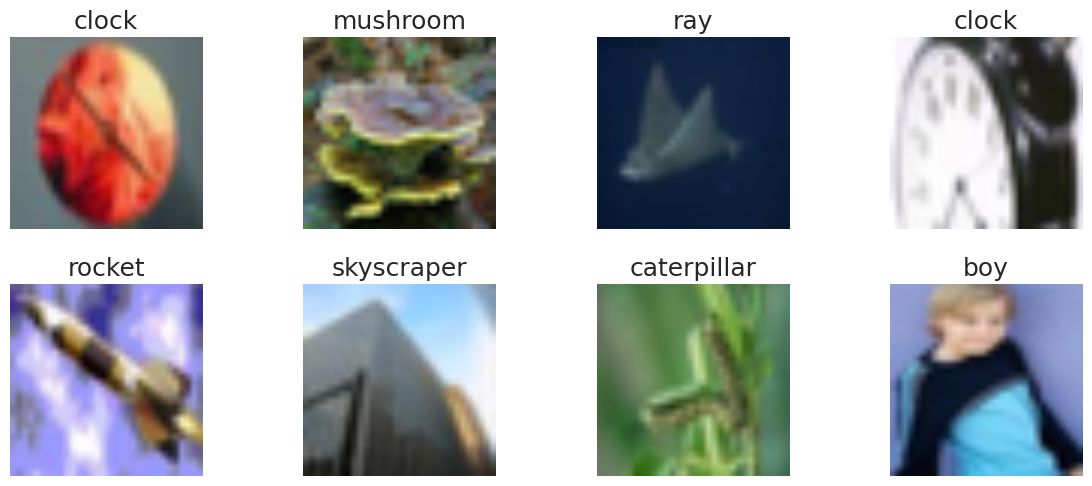

In [6]:
plt.figure(figsize=(12, 20), dpi=100)
for images, labels in iter(val_loader):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Modeling</div>

In [7]:
class LitModel(pl.LightningModule):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.model = models.googlenet(weights="IMAGENET1K_V1", transform_input=False)
#         for param in self.model.parameters():
#             param.requires_grad = False
        self.model.fc = nn.Linear(1024, num_classes)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=False, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        acc = self.accuracy(y_hat, y)
        self.log('test_acc', acc)

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        y_hat = self(x)
        preds = torch.argmax(y_hat, dim=1)
        return preds

In [8]:
num_classes = 100
model = LitModel(num_classes=num_classes)
logger = CSVLogger("./")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=5, verbose=False, mode="min")
trainer = pl.Trainer(max_epochs=100, enable_progress_bar=True, logger=logger, callbacks=[early_stop_callback])
trainer.fit(model, train_loader, val_loader)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 206MB/s]
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDI

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [9]:
trainer.test(model, val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7311999797821045     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.7311999797821045}]

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Predict Test Data</div>

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

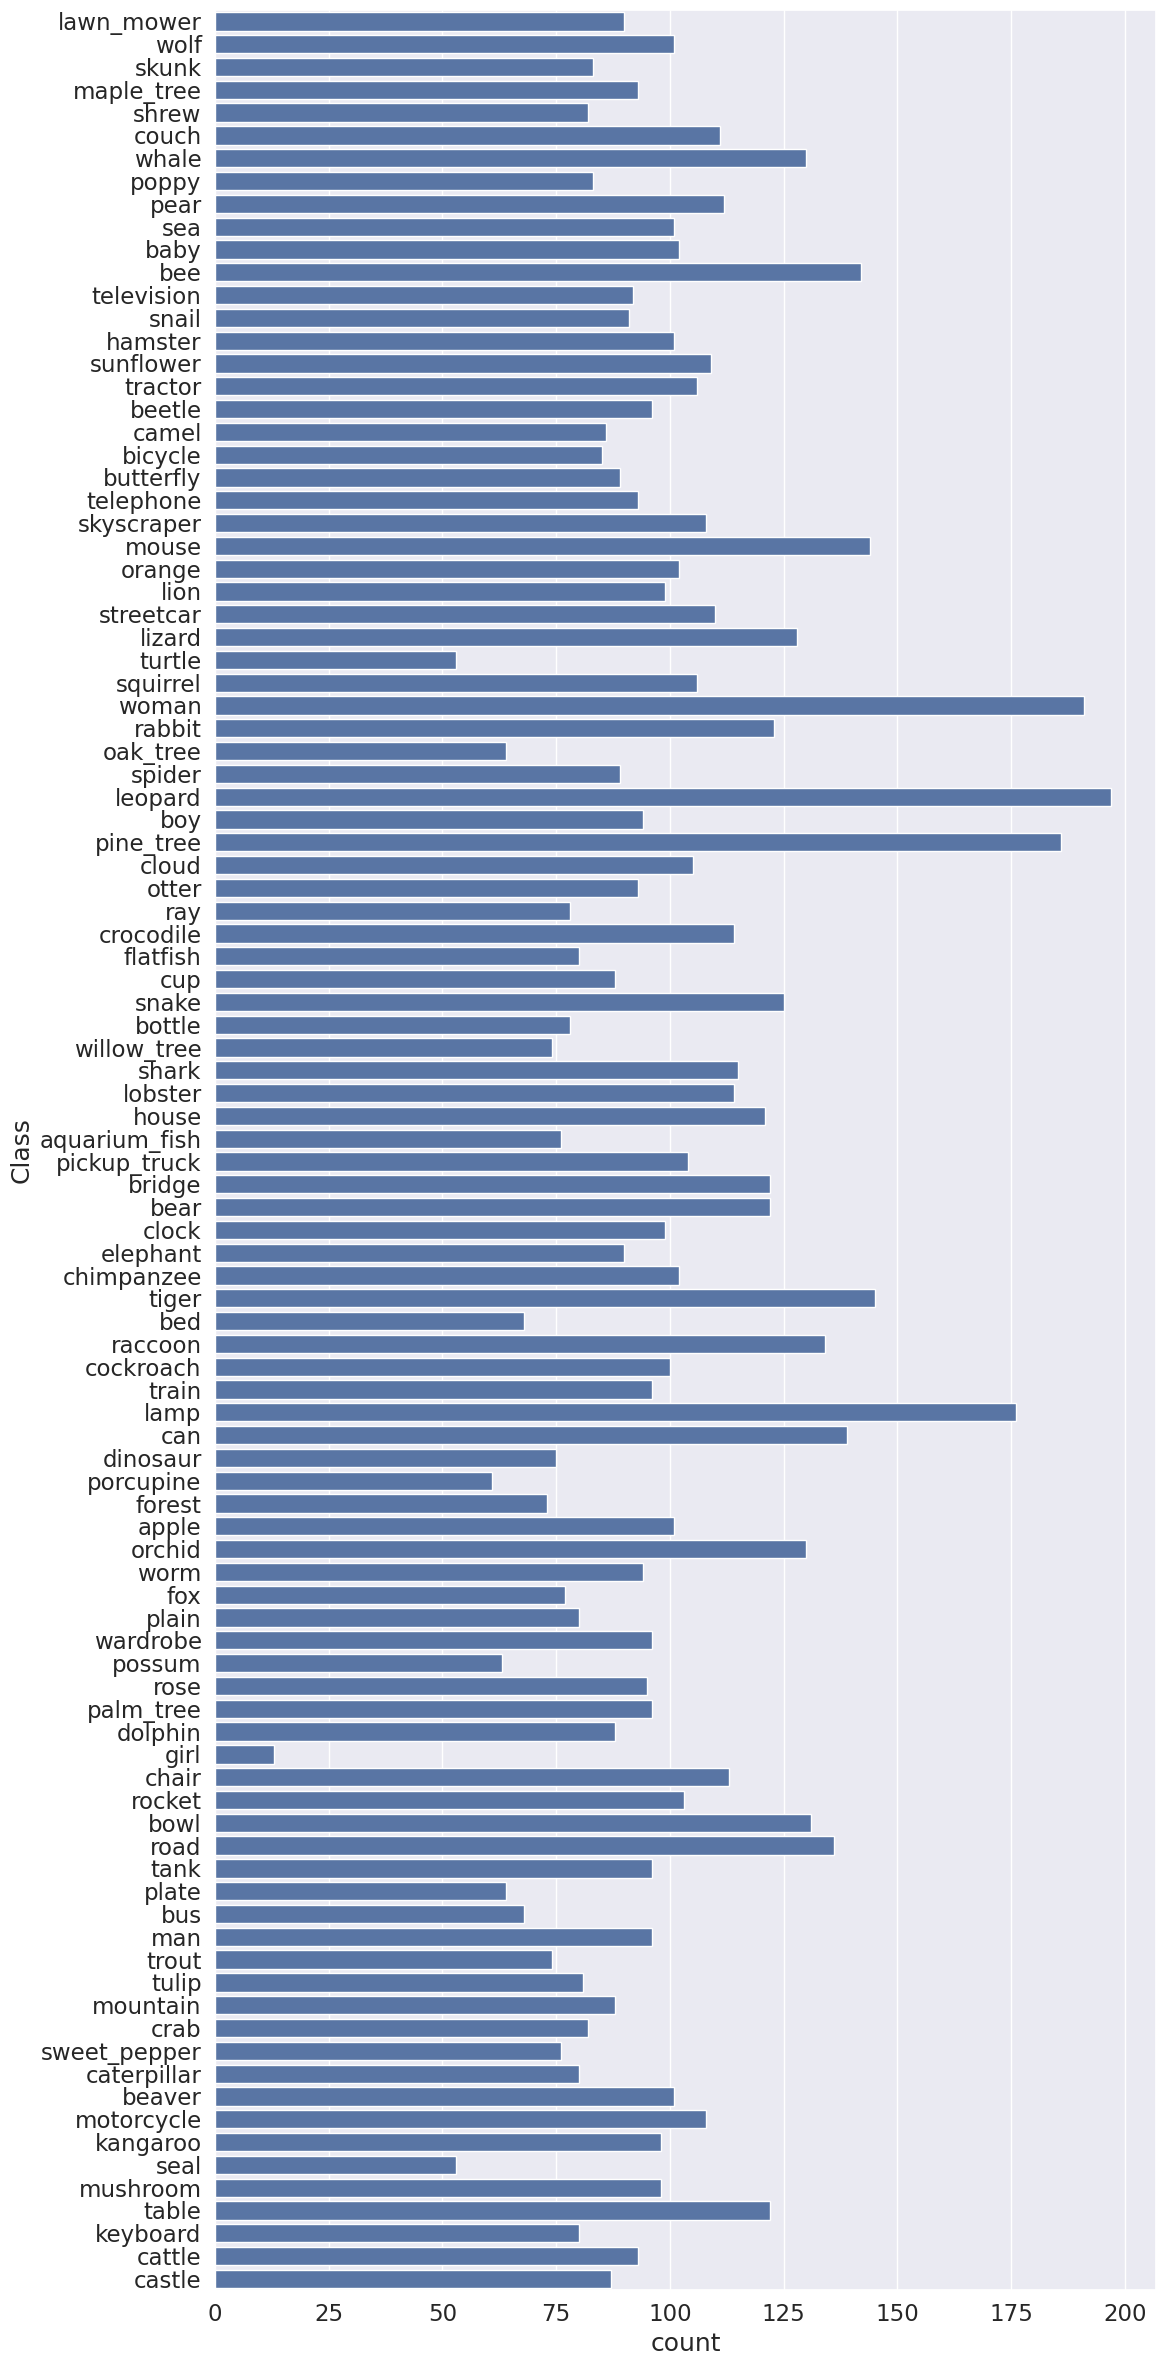

In [10]:
pred = trainer.predict(model, test_loader)
pred = torch.cat(pred, dim=0)
pred = pd.DataFrame(pred.numpy(), columns=["Class"])
pred["Class"] = pred["Class"].apply(lambda x: class_names[x])

plt.figure(figsize=(12, 24), dpi=100)
sns.countplot(y="Class", data=pred)
plt.tight_layout()
plt.show()

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Loss & Accuracy</div>

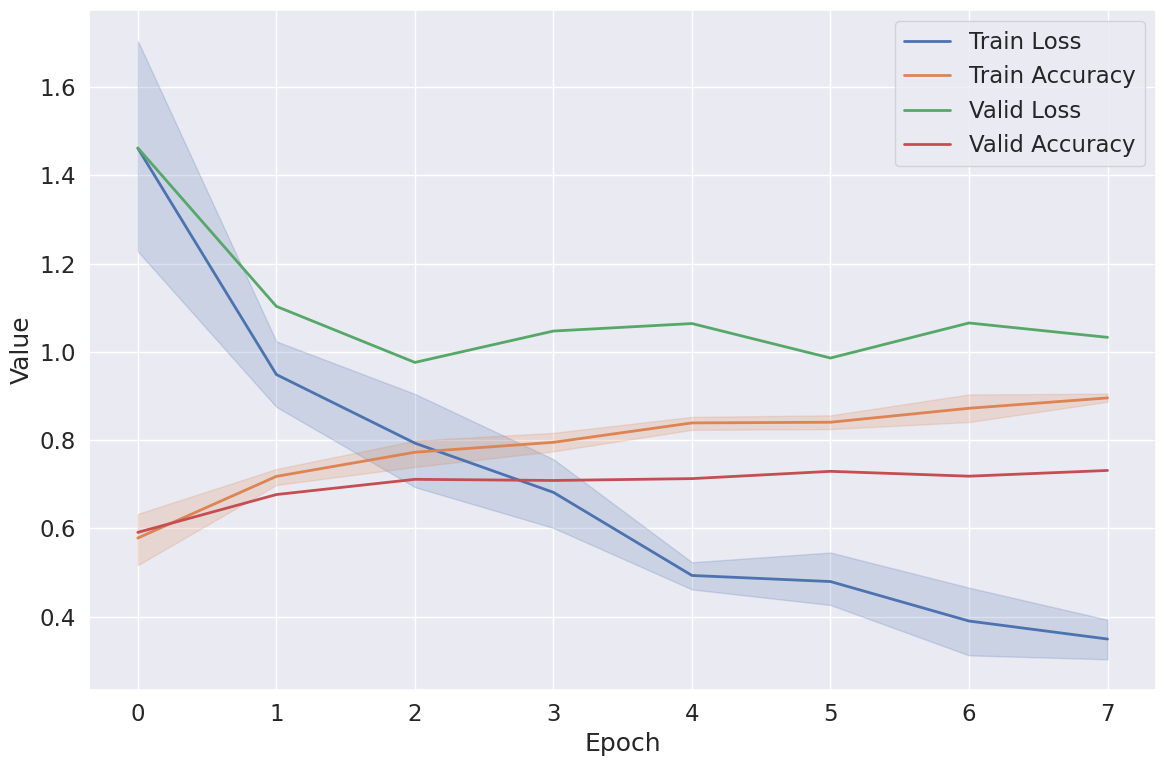

In [11]:
log_path = logger.log_dir + "/metrics.csv"
metrics = pd.read_csv(log_path)

plt.figure(figsize=(12, 8), dpi=100)
sns.lineplot(x="epoch", y="train_loss", data=metrics, label="Train Loss", linewidth=2)
sns.lineplot(x="epoch", y="train_acc", data=metrics, label="Train Accuracy", linewidth=2)
sns.lineplot(x="epoch", y="val_loss", data=metrics, label="Valid Loss", linewidth=2)
sns.lineplot(x="epoch", y="val_acc", data=metrics, label="Valid Accuracy", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.tight_layout()
plt.show()